This Python notebook is a tutorial script on the combinatorial expansion of the current legacy dataset from Darby et. al on Single Atom Alloys. The analysis is as follows:

1. Intialize legacy dataset
2. Create a library of descriptors
3. Dimensionality Reduction
4. Gaussian Process Regression
5. Cross Validation
6. Combinatorial Expansion
7. Novelty Detection

In [1]:
#Import necessary modules
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#plt.style.use('classic')
plt.style.use('seaborn-white')
mpl.rcParams['grid.color']= 'white'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.manifold import Isomap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import(RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel, WhiteKernel)
import seaborn as sns
from mpl_toolkits import mplot3d

from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.neighbors import LocalOutlierFactor

#Random seed to improve reproducibility
from numpy.random import seed
seed(5)

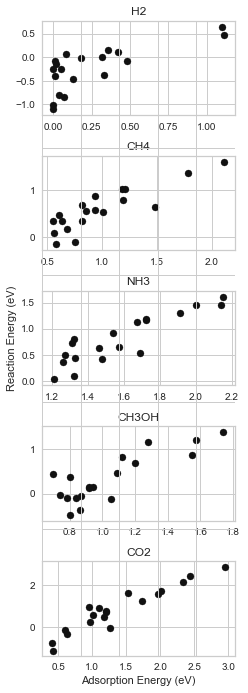

In [54]:
#Initialize legacy dataset

#Reaction Energy, Adsorption Energy and Spillover Energy from existing databases
rxn_data = pd.read_excel('Response_SAA.xlsx')
rxn_data = rxn_data.set_index('Species')
rxndata = rxn_data.iloc[:,0:15]

#Plot the dataset - activation energy vs reaction energy
fig,ax = plt.subplots(ncols=1,nrows=5, figsize=(4,10))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax[0].scatter(rxn_data.iloc[:,0],rxn_data.iloc[:,1], c='k')
ax[0].title.set_text('H2')
ax[1].scatter(rxn_data.iloc[:,3],rxn_data.iloc[:,4], c='k')
ax[1].title.set_text('CH4')
ax[2].scatter(rxn_data.iloc[:,6],rxn_data.iloc[:,7], c='k')
ax[2].title.set_text('NH3')
ax[3].scatter(rxn_data.iloc[:,9],rxn_data.iloc[:,10], c='k')
ax[3].title.set_text('CH3OH')
ax[4].scatter(rxn_data.iloc[:,12],rxn_data.iloc[:,13], c='k')
ax[4].title.set_text('CO2')
plt.xlabel('Adsorption Energy (eV)')
plt.ylabel('Reaction Energy (eV)')
plt.tight_layout()
#fig.savefig('Legacy2.png',dpi=1200)


#Descriptor Database
#elements = pd.read_excel('Elements.xlsx')
#elements = elements.set_index('Symbol')

In [3]:
#Create descriptor database for existing SAAs and elements
#This step also creates the larger combinatorial library which will be used in subsequent steps
small_dataset = pd.DataFrame()
species = rxn_data.index

atom1 = elements.index
Comb_lib = list(itertools.permutations(atom1,2))

New_names = [0]*len(Comb_lib)
i=0
for name in Comb_lib:
    New_names[i] = ((''.join(filter(str.isalnum, name))))
    i=i+1
    
Name_data = New_names

New_names2 = [0]*len(species)

a = 0
for el in elements.index:
    if el in species:
        New_names2[a] = el
        a = a + 1
        
for name in Name_data:
    if name in species:
        New_names2[a] = name
        a = a + 1
        
small_dataset['Species'] = New_names2
small_dataset = small_dataset.set_index('Species')

Comblib = np.zeros((len(Comb_lib),21))
j = 0
for (sur1, sur2) in Comb_lib:
    Comblib[j,:] = (0.5*(elements.loc[sur1]) + 0.5*(elements.loc[sur2]))
    j = j + 1
    
Comb_df = pd.DataFrame(Comblib)
Comb_df['Alloy'] = New_names
Comb_df = Comb_df.set_index('Alloy')
Comb_df.columns = elements.columns
Comb_df = Comb_df.append(elements)

for col in Comb_df.columns:
    small_dataset[col] = small_dataset.index.map(Comb_df[col])

In [4]:
small_dataset

,Atomic Number,Number of atoms in a unit cell,"Valence electron number, Nv",Pseudopotential core radii sum R=rs+rp,Atomic Radius (Å),Density @ 293 K (g/cm³),First Ionization Potential (eV),Pauling electronegativity,Melting Point (K),Boiling Point (K),...,Work Function (eV),Specific Heat (J/gK),Heat of Fusion (kJ/mol),Heat of Vaporization (kJ/mol),Heat Capacity (J/mol.K),Debye Temp (K),Thermal Conductivity at 300K (W/cmK),Coeficient of Thermal Expansion (10^-6 K^-1),Electrical Resistivity (10^-8 Ω m) at above 273K,Wigner - Seitz Cell Density
Species,,,,,,,,,,,,,,,,,,,,,
Ni,28.0,4.0,10.0,2.1800,1.250,8.902,7.630,1.910,1726.00,3005.0,...,5.150,0.4400,17.470,370.40,26.070,450.0,0.9070,13.30,6.8400,5.360
Cu,29.0,4.0,11.0,2.0400,1.280,8.960,7.720,1.900,1356.60,2840.0,...,4.650,0.3800,13.050,300.30,24.440,343.0,4.0100,16.50,1.6730,3.180
Rh,45.0,4.0,9.0,2.5200,1.340,12.410,7.460,2.280,2239.00,4000.0,...,4.980,0.2420,21.500,493.00,24.980,480.0,1.5000,8.40,4.5100,5.450
Pd,46.0,4.0,10.0,2.4500,1.380,12.020,8.330,2.200,1825.00,3413.0,...,5.120,0.2400,17.600,357.00,25.980,274.0,0.7180,11.20,10.8000,4.660
Ag,47.0,4.0,11.0,2.3750,1.440,10.500,7.570,1.930,1235.08,2485.0,...,4.260,0.2350,11.300,250.58,25.350,225.0,4.2900,19.20,1.5900,2.520
Pt,78.0,4.0,10.0,2.7000,1.380,21.450,8.960,2.280,2045.00,4100.0,...,5.650,0.1300,19.600,510.00,25.860,240.0,0.7160,9.00,10.6000,5.640
Au,79.0,4.0,11.0,2.6600,1.440,19.320,9.220,2.540,1337.58,3080.0,...,5.100,0.1280,12.550,334.40,25.418,165.0,3.1700,14.16,2.3500,3.870
NiCu,28.5,4.0,10.5,2.1100,1.265,8.931,7.675,1.905,1541.30,2922.5,...,4.900,0.4100,15.260,335.35,25.255,396.5,2.4585,14.90,4.2565,4.270
NiAg,37.5,4.0,10.5,2.2775,1.345,9.701,7.600,1.920,1480.54,2745.0,...,4.705,0.3375,14.385,310.49,25.710,337.5,2.5985,16.25,4.2150,3.940


In [4]:
pca_dataset = small_dataset.copy(deep=True)

pca_dataset['H2a'] = pca_dataset.index.map(rxn_data.iloc[:,0])
pca_dataset['H2r'] = pca_dataset.index.map(rxn_data.iloc[:,1])
pca_dataset['CH4a'] = pca_dataset.index.map(rxn_data.iloc[:,3])
pca_dataset['CH4r'] = pca_dataset.index.map(rxn_data.iloc[:,4])
pca_dataset['NH3a'] = pca_dataset.index.map(rxn_data.iloc[:,6])
pca_dataset['NH3r'] = pca_dataset.index.map(rxn_data.iloc[:,7])
pca_dataset['CH3OHa'] = pca_dataset.index.map(rxn_data.iloc[:,9])
pca_dataset['CH3OHr'] = pca_dataset.index.map(rxn_data.iloc[:,10])
pca_dataset['CO2a'] = pca_dataset.index.map(rxn_data.iloc[:,12])
pca_dataset['CO2r'] = pca_dataset.index.map(rxn_data.iloc[:,13])

#Making different datasets for different adsorbates
tot_pca = pca_dataset.copy(deep=True)

H2r_pca = pca_dataset.iloc[:,1:22]

In [6]:
rxn_data.index

Index(['Ag', 'Au', 'Cu', 'Ni', 'Pd', 'Pt', 'Rh', 'NiAg', 'NiAu', 'NiCu',
       'PdAg', 'PdAu', 'PdCu', 'PtAg', 'PtAu', 'PtCu', 'RhAg', 'RhAu', 'RhCu'],
      dtype='object', name='Species')

In [7]:
#small_dataset.to_excel('Small_dataset.xlsx')

[0.59895558 0.22976898 0.06319544 0.04256753 0.03163089 0.01471385
 0.01083378 0.00297151 0.00225925 0.00115378]
[[-4.90104596e+00 -4.27705020e+00  3.09702816e+00 -1.09431096e+00
  -2.18303792e-01 -6.17203181e-01  6.83640822e-01  5.94582642e-02
   2.80295223e-01 -2.25355762e-01]
 [ 2.70643891e+00 -3.20205407e+00 -2.20787885e+00 -5.30509002e-01
   2.27256456e+00 -4.78246046e-01 -3.12872796e-01  3.09784347e-02
   4.01176079e-01  1.30373245e-01]
 [-7.42337617e+00  5.65479805e-01 -1.96245784e+00 -5.01103907e-01
  -1.69608374e+00 -1.08557587e+00  6.10788095e-01 -8.64687906e-02
  -1.35299268e-01 -4.87817648e-02]
 [-3.00316392e+00 -1.62990180e-01  1.13501483e+00  3.05844623e+00
  -2.45668988e-02 -6.38097459e-01 -3.45298728e-01  4.36867034e-01
   1.92170364e-01 -1.14345089e-02]
 [ 1.09105260e+01 -2.42165616e+00 -1.21738413e+00  3.86556903e-01
  -1.21672259e+00 -6.39716784e-02  1.25897084e+00 -2.66362280e-01
   2.02772978e-01  1.35494147e-02]
 [-5.16615190e+00  4.39427099e+00  4.87096978e-01  2

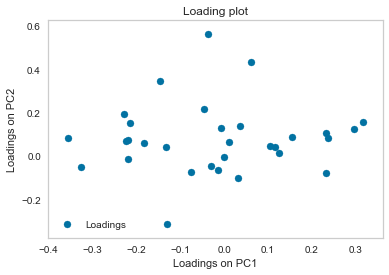

In [5]:
#Assessment of feature importance. We perform Principal Component Analysis on the dataset and assess the importance
#and correlation of each variable with the training variables. 

pca_data = preprocessing.normalize(tot_pca)
pca_scale = preprocessing.StandardScaler()
pca_data_update = pca_scale.fit_transform(pca_data)

pca_vip = PCA(n_components=10)

pca_vip.fit(pca_data_update)

print(pca_vip.explained_variance_ratio_)

loadings = pca_vip.components_

loadings_df = pd.DataFrame(loadings)

plt.scatter(loadings[1,:], loadings[2,:], label="Loadings")
plt.title("Loading plot");
plt.xlabel("Loadings on PC1");
plt.ylabel("Loadings on PC2");
plt.grid();
plt.legend(loc='lower left');

loadings_df.to_excel('Loadings_PCA_check.xlsx')

print(pca_vip.transform(pca_data_update))

In [9]:
###Ignore this code snippet

#Create predictive model on smaller dataset

#For the predictive model we will create a pipeline with 3 steps: k-fold cross validation -> Isomap -> GPR

#kf = KFold(n_splits=5)
#embedding = Isomap(n_neighbors=5, n_components=10)
#kernel = DotProduct() + WhiteKernel()
#gpr = GaussianProcessRegressor(kernel=kernel,random_state=123)
#predict_gpr = Pipeline([('kfold',kf),('Ismp',embedding),('gpr',gpr)])

In [6]:
#Remove the repeat values in Comb_df
Comb_df = Comb_df.drop_duplicates(subset=['Atomic Number','Number of atoms in a unit cell', 'Valence electron number, Nv', 'First Ionization Potential (eV)'],keep='first')

[12893.117522817884, 9183.24415185456, 5771.052446700736, 4413.509734219462, 3082.036393260176, 2552.3122223958067, 1965.5655156141856, 1575.5323666021322, 1454.5366305013504, 927.997339673173, 934.6171001518723, 733.9453393774969, 712.0162104748491]
Optimal number of nearest neighbours is 11
927.997339673173


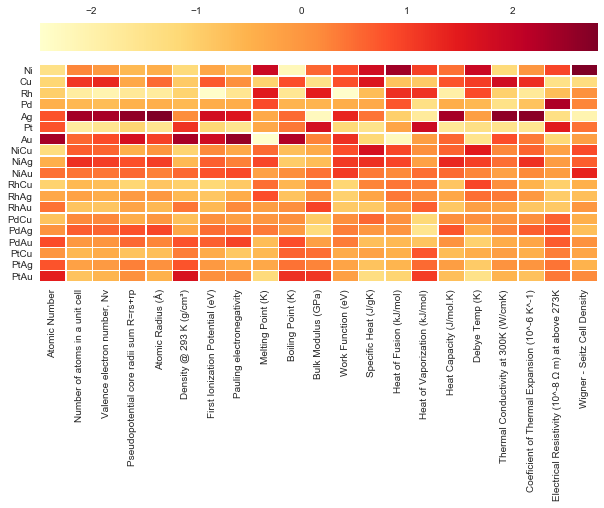

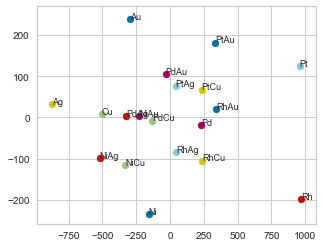

In [7]:
#Isomap on smaller dataset to identify optimum number of nearest neighbours

small_data = small_dataset.iloc[:,0:21]
small_data = preprocessing.normalize(small_data)
scaler = preprocessing.StandardScaler()
smalldata = scaler.fit_transform(small_data)

fig = plt.figure(figsize=(10,5))
ax = sns.heatmap(smalldata, linewidth=0.5, cmap='YlOrRd', yticklabels=small_dataset.index,xticklabels=small_dataset.columns, cbar_kws = dict(use_gridspec=False,location="top")) #, cbar=False)
fig.savefig('Fig3_cb.png', dpi=600)

#Identify the optimum number of neighbours and then generate the final Isomap
err = []
for u in range(2,15):
    ism = Isomap(n_neighbors=u,n_components=10,neighbors_algorithm='kd_tree')
    y = ism.fit_transform(small_dataset) 
    err.append(ism.reconstruction_error())
    
print(err)
    
#fig = plt.figure()
#plt.plot(err)
#plt.show()
    #fig = plt.figure(figsize=(5, 4))
    #ax = fig.add_axes([0,0, .8, 1])
    #ax.scatter(y[:, 0], -y[:, 1])
    #plt.show()

err_diff = []
for m in range(1,len(err)):
    err_diff = err[m-1] - err[m]
    if(err_diff<0):
        print("Optimal number of nearest neighbours is %d" % (m+1))
        break
        
opt_nbrs = (m+1)

ism = Isomap(n_neighbors=opt_nbrs,n_components=10,neighbors_algorithm='kd_tree')
y = ism.fit_transform(small_dataset) 
print(ism.reconstruction_error())
fig = plt.figure(figsize=(5, 4))
for i,type in enumerate(New_names2):
    xa = y[i,0]
    ya = y[i,1]
    plt.scatter(xa, ya)
    plt.text(xa+0.3, ya+0.3, type, fontsize=9)
#plt.savefig('Figure_a.png',dpi=600)
plt.show()

In [12]:
print(len(Comb_df))

300


In [8]:
#kf = KFold(n_splits=5)
#embedding = Isomap(n_neighbors=opt_nbrs, n_components=9)
#kernel=1.0 * RBF(length_scale=6.0)
kernel = DotProduct() + WhiteKernel()
#kernel = DotProduct()
#kernel=1.0 * RBF(length_scale=4.0, length_scale_bounds=(1e-1, 10.0))
#kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
#kernel=  ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)
#kernel=1.0 * Matern()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=123)

In [14]:
#No need for k-fold cross validation in Gaussian Process
"""
kf.get_n_splits(small_dataset)
for train_index, test_index in kf.split(small_dataset):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = small_dataset.iloc[train_index], small_dataset.iloc[test_index]
    y_train, y_test = rxn_data.iloc[train_index], rxn_data.iloc[test_index]
    Xtr_transformed = embedding.fit_transform(X_train)
    
    #Hydrogen adsorption, reaction and spillover energy
    
    #Adsorption
    ytr_h2_a = y_train.iloc[:,1]
    gpr_h2_a = gpr.fit()
    
"""

#y_h2_a

'\nkf.get_n_splits(small_dataset)\nfor train_index, test_index in kf.split(small_dataset):\n    print("TRAIN:", train_index, "TEST:", test_index)\n    X_train, X_test = small_dataset.iloc[train_index], small_dataset.iloc[test_index]\n    y_train, y_test = rxn_data.iloc[train_index], rxn_data.iloc[test_index]\n    Xtr_transformed = embedding.fit_transform(X_train)\n    \n    #Hydrogen adsorption, reaction and spillover energy\n    \n    #Adsorption\n    ytr_h2_a = y_train.iloc[:,1]\n    gpr_h2_a = gpr.fit()\n    \n'

In [9]:
err_check = []
for u1 in range(2,15):
    ism = Isomap(n_neighbors=u1,n_components=10,neighbors_algorithm='kd_tree')
    y_check = ism.fit_transform(Comb_df) 
    err_check.append(ism.reconstruction_error())
    
print(err_check)


err_diff_check = []
for m in range(1,len(err_check)):
    err_diff_check = err_check[m-1] - err_check[m]
    if(err_diff_check<0):
        print("Optimal number of nearest neighbours is %d" % (m+1))
        break
        
opt_nbrs_check = (m+1)

ism_big = Isomap(n_neighbors=opt_nbrs_check,n_components=10,neighbors_algorithm='kd_tree')
y_big = ism_big.fit_transform(Comb_df) 
print(ism_big.reconstruction_error())

[1030430.1083188639, 68706.11248040422, 34739.39755737345, 33027.71330303891, 27253.783411749966, 23388.362987312965, 23404.94348437621, 25892.684590225268, 22144.325041906333, 23244.673841790078, 21512.068323704567, 21800.610491985975, 20637.01146616384]
Optimal number of nearest neighbours is 7
23388.362987312965


In [10]:
#for i in range (2,10):
embedding = Isomap(n_neighbors=opt_nbrs, n_components=7)
embedding2 = Isomap(n_neighbors=7,n_components=7)
X_transformed = embedding.fit_transform(smalldata)
Comblib_transformed = embedding2.fit_transform(Comb_df)
#print(X_transformed)


#Hydrogen Adsorption 
y_h2_a = np.asarray(rxn_data.iloc[:,0])
gpr_h2_a = gpr.fit(X_transformed,y_h2_a)
score_h2_a = gpr_h2_a.score(X_transformed,y_h2_a)
preds_h2_a = gpr_h2_a.predict(Comblib_transformed,return_std=True)
print(score_h2_a)

#Hydrogen Reaction 
y_h2_r = rxn_data.iloc[:,1]
gpr_h2_r = gpr.fit(X_transformed,y_h2_r)
score_h2_r = gpr_h2_r.score(X_transformed,y_h2_r)
preds_h2_r = gpr_h2_r.predict(Comblib_transformed,return_std=True)
print(score_h2_r)

#Methane Adsorption 
y_ch4_a = rxn_data.iloc[:,3]
gpr_ch4_a = gpr.fit(X_transformed,y_ch4_a)
score_ch4_a = gpr_ch4_a.score(X_transformed,y_ch4_a)
preds_ch4_a = gpr_ch4_a.predict(Comblib_transformed,return_std=True)
print(score_ch4_a)

#Methane Reaction 
y_ch4_r = rxn_data.iloc[:,4]
gpr_ch4_r = gpr.fit(X_transformed,y_ch4_r)
score_ch4_r = gpr_ch4_r.score(X_transformed,y_ch4_r)
preds_ch4_r = gpr_ch4_r.predict(Comblib_transformed,return_std=True)
print(score_ch4_r)

#Ammonia Adsorption 
y_nh3_a = rxn_data.iloc[:,6]
gpr_nh3_a = gpr.fit(X_transformed,y_nh3_a)
score_nh3_a = gpr_nh3_a.score(X_transformed,y_nh3_a)
preds_nh3_a = gpr_nh3_a.predict(Comblib_transformed,return_std=True)
print(score_nh3_a)

#Ammonia Reaction 
y_nh3_r = rxn_data.iloc[:,7]
gpr_nh3_r = gpr.fit(X_transformed,y_nh3_r)
score_nh3_r = gpr_nh3_r.score(X_transformed,y_nh3_r)
preds_nh3_r = gpr_nh3_r.predict(Comblib_transformed,return_std=True)
print(score_nh3_r)

#Methanol Adsorption 
y_ch3oh_a = rxn_data.iloc[:,9]
gpr_ch3oh_a = gpr.fit(X_transformed,y_ch3oh_a)
score_ch3oh_a = gpr_ch3oh_a.score(X_transformed,y_ch3oh_a)
preds_ch3oh_a = gpr_ch3oh_a.predict(Comblib_transformed,return_std=True)
print(score_ch3oh_a)

#Methanol Reaction 
y_ch3oh_r = rxn_data.iloc[:,10]
gpr_ch3oh_r = gpr.fit(X_transformed,y_ch3oh_r)
score_ch3oh_r = gpr_ch3oh_r.score(X_transformed,y_ch3oh_r)
preds_ch3oh_r = gpr_ch3oh_r.predict(Comblib_transformed,return_std=True)
print(score_ch3oh_r)

#Carbon Dioxide Adsorption 
y_co2_a = rxn_data.iloc[:,12]
gpr_co2_a = gpr.fit(X_transformed,y_co2_a)
score_co2_a = gpr_co2_a.score(X_transformed,y_co2_a)
preds_co2_a = gpr_co2_a.predict(Comblib_transformed,return_std=True)
print(score_co2_a)

#Carbon Dioxide Reaction 
y_co2_r = rxn_data.iloc[:,13]
gpr_co2_r = gpr.fit(X_transformed,y_co2_r)
score_co2_r = gpr_co2_r.score(X_transformed,y_co2_r)
preds_co2_r = gpr_co2_r.predict(Comblib_transformed,return_std=True)
print(score_co2_r)
    
print("==========================================================================")

0.602754584071242
0.6506973499666174
0.6897653190421071
0.8103383354930626
0.5645209477502409
0.6151944695154823
0.5324765095246714
0.39525267210398457
0.7092297040141206
0.6883168169943672


In [17]:
#Ignore this snippet
#fig = plt.figure()#figsize=[15,10])
#ax = plt.axes()
#sc = ax.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], c=preds_h2_a[0], cmap='jet')
#fig.colorbar(sc)
#fig.savefig('Demo.png', dpi=600)

In [29]:
rescaler = MinMaxScaler(feature_range=(-1,1),copy=True)

#Hydrogen
h2_a_prediction = preds_h2_a[0].reshape(-1,1)
h2_a_prediction = rescaler.fit_transform(h2_a_prediction)

h2_r_prediction = preds_h2_r[0].reshape(-1,1)
h2_r_prediction = rescaler.fit_transform(h2_r_prediction)


#Ammonia
nh3_a_prediction = preds_nh3_a[0].reshape(-1,1)
nh3_a_prediction = rescaler.fit_transform(nh3_a_prediction)

nh3_r_prediction = preds_nh3_r[0].reshape(-1,1)
nh3_r_prediction = rescaler.fit_transform(nh3_r_prediction)

#Methane
ch4_a_prediction = preds_ch4_a[0].reshape(-1,1)
ch4_a_prediction = rescaler.fit_transform(ch4_a_prediction)

ch4_r_prediction = preds_ch4_r[0].reshape(-1,1)
ch4_r_prediction = rescaler.fit_transform(ch4_r_prediction)

#Methanol
ch3oh_a_prediction = preds_ch3oh_a[0].reshape(-1,1)
ch3oh_a_prediction = rescaler.fit_transform(ch3oh_a_prediction)

ch3oh_r_prediction = preds_ch3oh_r[0].reshape(-1,1)
ch3oh_r_prediction = rescaler.fit_transform(ch3oh_r_prediction)

#Carbon Dioxide
co2_a_prediction = preds_co2_a[0].reshape(-1,1)
co2_a_prediction = rescaler.fit_transform(co2_a_prediction)

co2_r_prediction = preds_co2_r[0].reshape(-1,1)
co2_r_prediction = rescaler.fit_transform(co2_r_prediction)

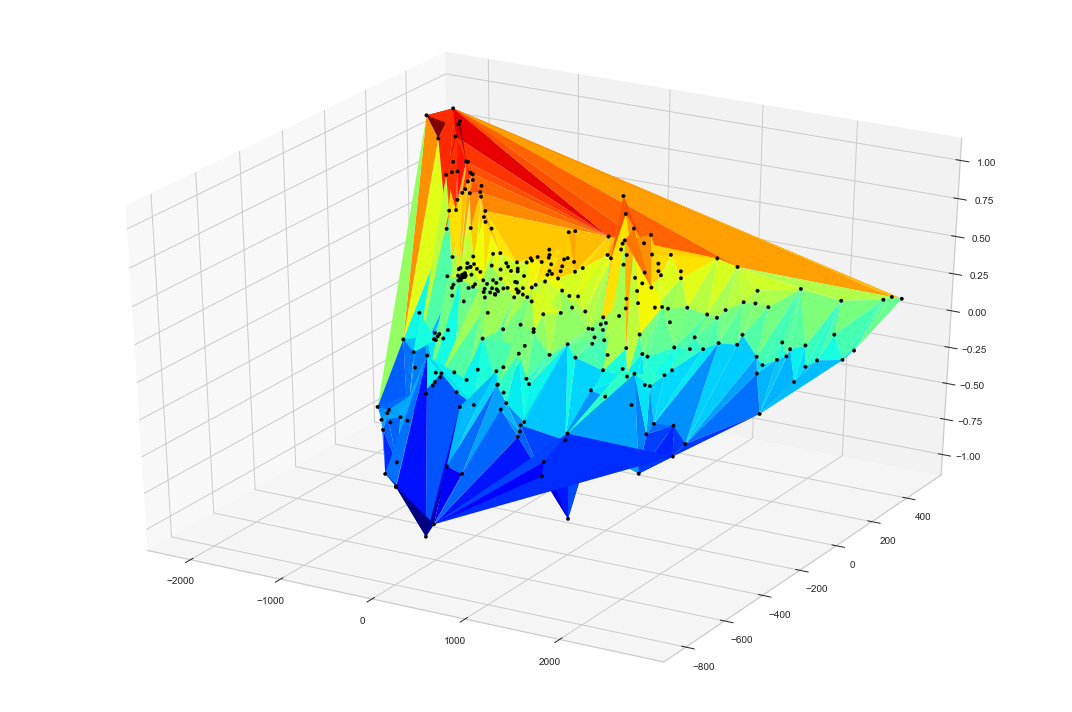

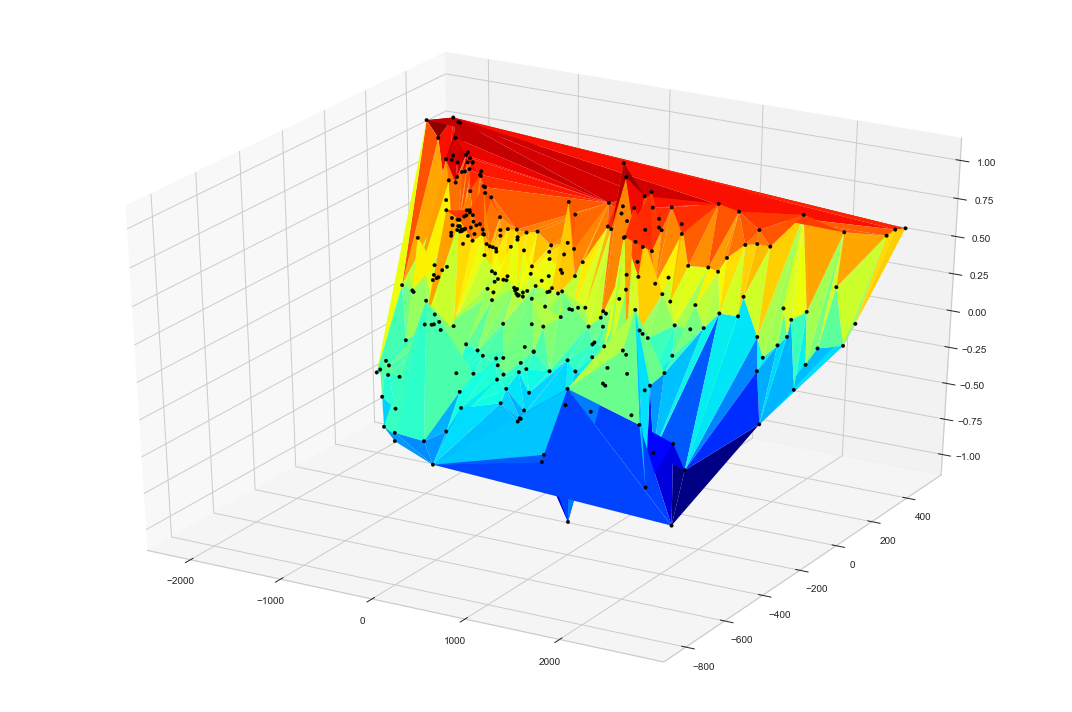

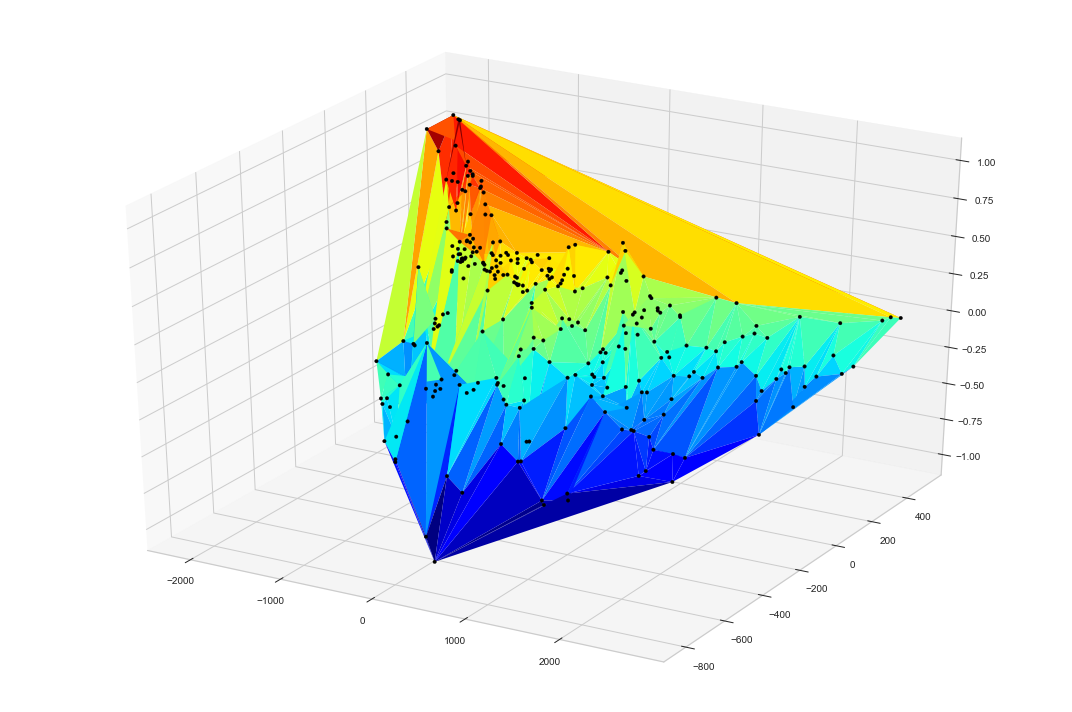

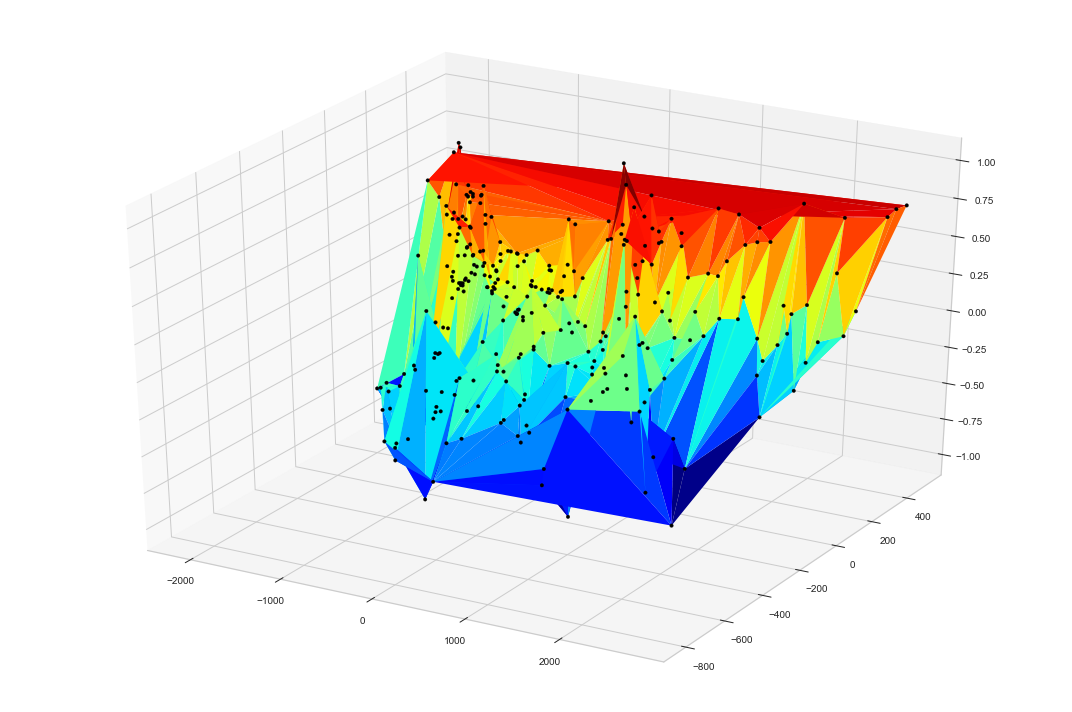

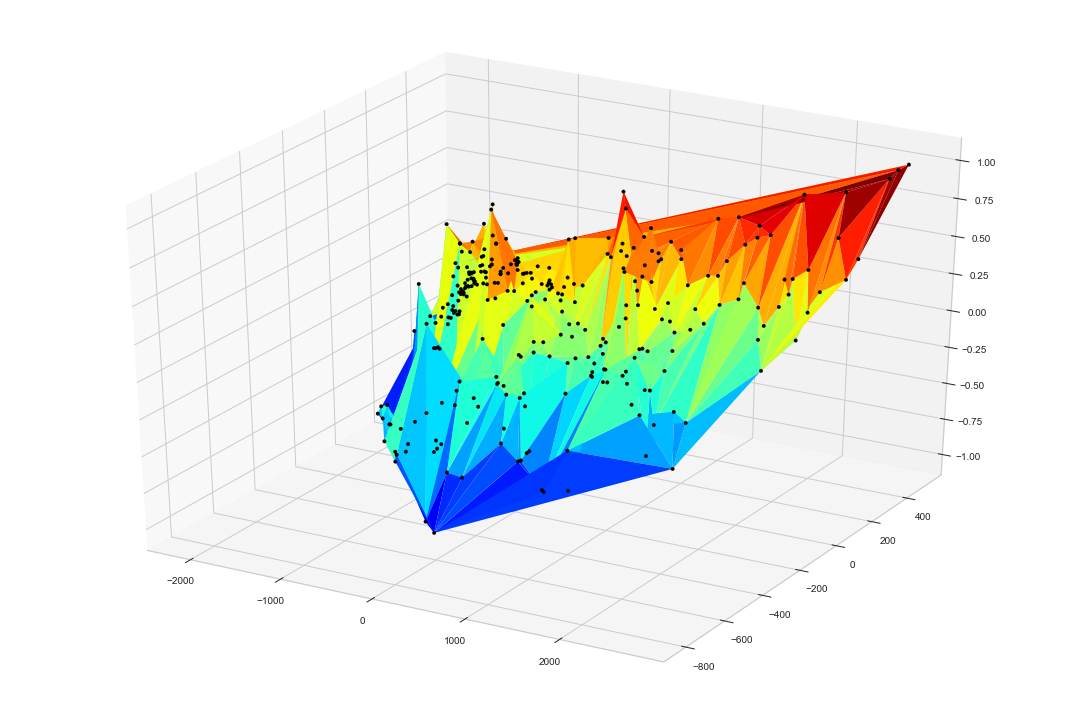

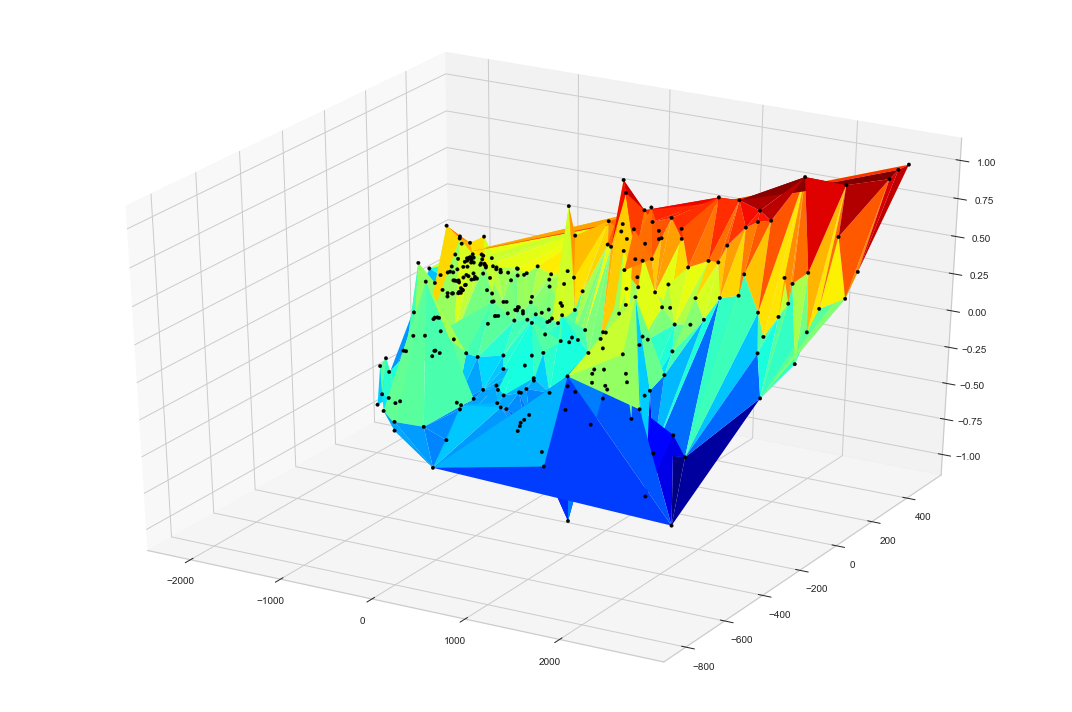

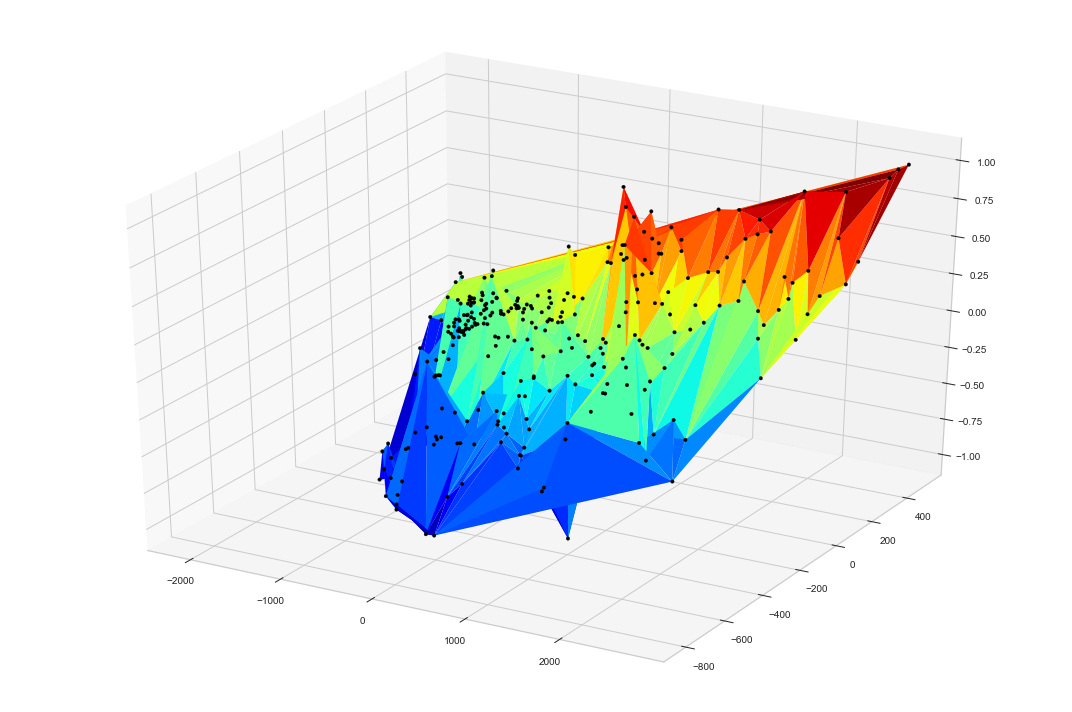

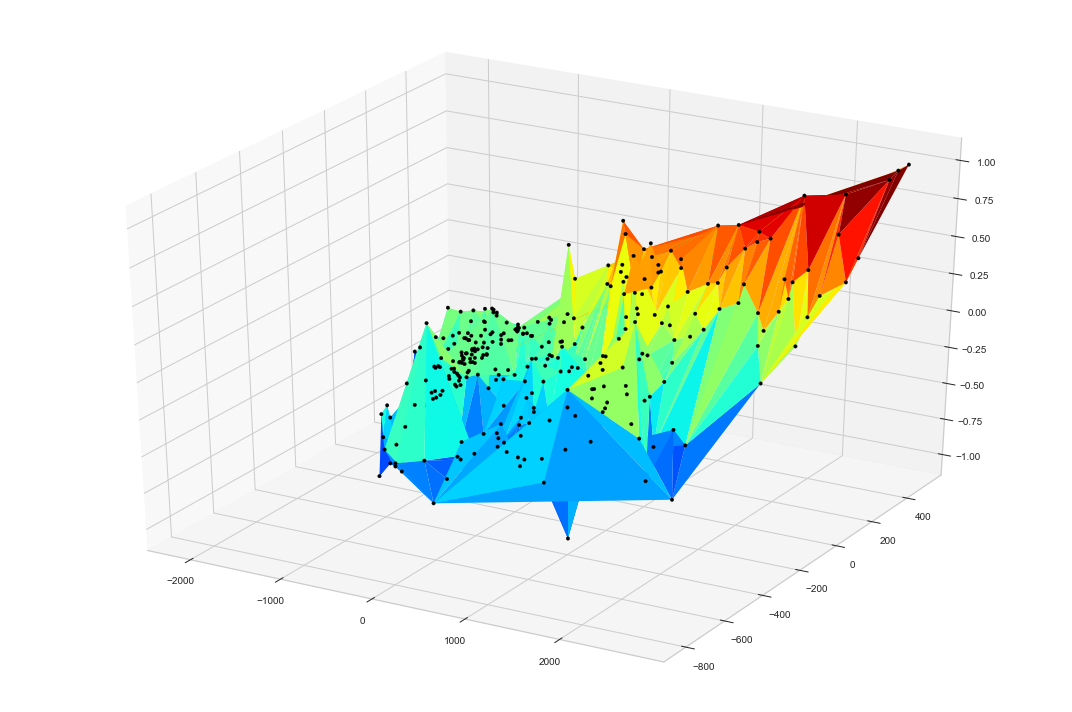

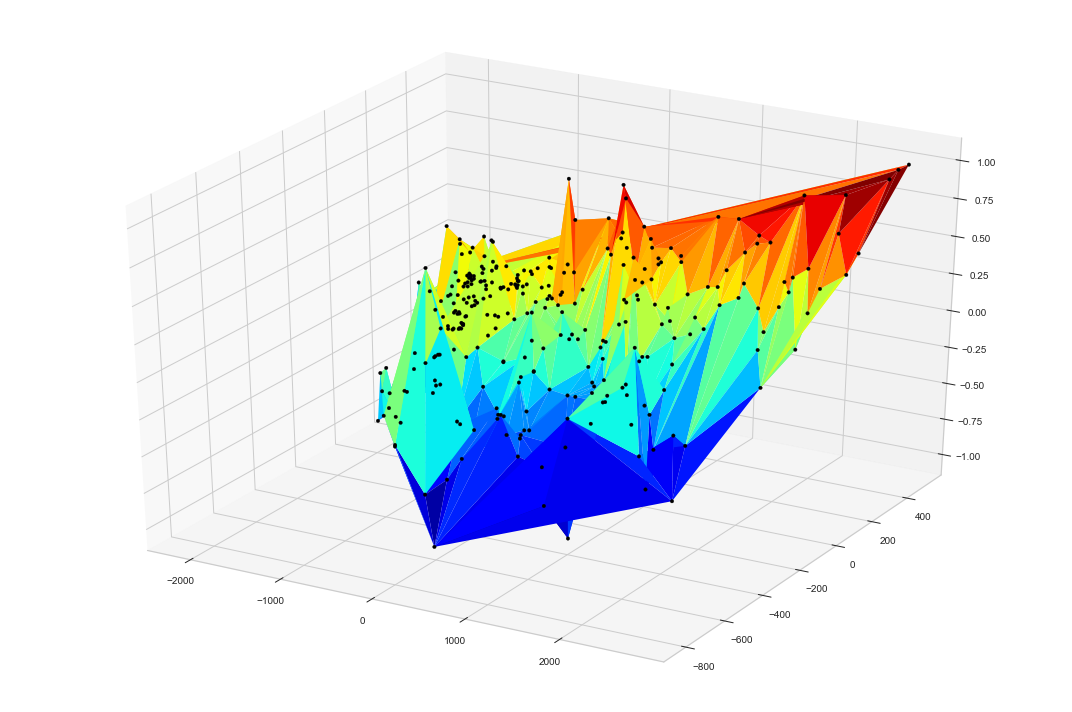

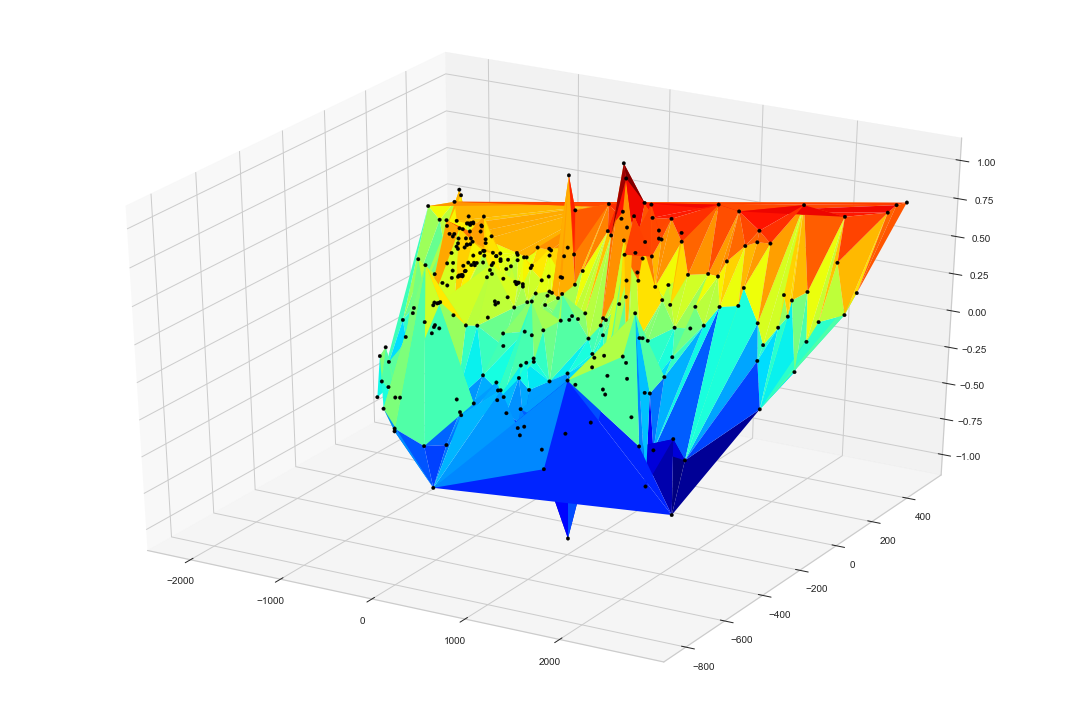

In [44]:
#Plot predicted surfaces
fig = plt.figure(figsize=[15,10])
ax = plt.axes(projection='3d')
ax.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], h2_a_prediction[:,0],
                cmap='jet', edgecolor='none')
ax.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], h2_a_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#for z in range(0,len(rxn_data)):
#    ax.scatter(X_transformed[z,0], X_transformed[z,1], y_h2_a[z],marker='o', s=100, c="red", alpha=1)
#    ax.text(X_transformed[z,0],X_transformed[z,1],y_h2_a[z],rxn_data.index[z])
#ax.view_init(elev=60, azim=-45)
ax.set_facecolor('white')
#ax.set_xlabel('Isomap 1')
#ax.set_ylabel('Isomap 2')
#ax.set_zlabel('Predicted Hydrogen Adsorption Energy (eV)')
plt.tight_layout()
fig.savefig('Manuscript_for_submission_SAA/H2_ad_en_v2.png',dpi=600)
plt.show()

fig1 = plt.figure(figsize=[15,10])
ax1 = plt.axes(projection='3d')
ax1.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], h2_r_prediction[:,0],
                cmap='jet', edgecolor='none')
ax1.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], h2_r_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax1.view_init(elev=60, azim=-45)
#ax1.set_xlabel('Isomap 1')
#ax1.set_ylabel('Isomap 2')
#ax1.set_zlabel('Predicted Hydrogen Reaction Energy (eV)')
fig1.savefig('Manuscript_for_submission_SAA/H2_rxn_en_v2.png',dpi=600)
plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=[15,10])
ax2 = plt.axes(projection='3d')
ax2.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], ch4_a_prediction[:,0],
                cmap='jet', edgecolor='none')
ax2.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], ch4_a_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax2.view_init(elev=60, azim=-45)

#ax2.set_xlabel('Isomap 1')
#ax2.set_ylabel('Isomap 2')
#ax2.set_zlabel('Predicted Methane Adsorption Energy (eV)')
plt.tight_layout()
fig2.savefig('Manuscript_for_submission_SAA/CH4_ad_en_v2.png',dpi=600)
plt.show()

fig3 = plt.figure(figsize=[15,10])
ax3 = plt.axes(projection='3d')
ax3.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], ch4_r_prediction[:,0],
                cmap='jet', edgecolor='none')
ax3.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], ch4_r_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax3.view_init(elev=60, azim=-45)

#ax3.set_xlabel('Isomap 1')
#ax3.set_ylabel('Isomap 2')
#ax3.set_zlabel('Predicted Methane Reaction Energy (eV)')
plt.tight_layout()
fig3.savefig('Manuscript_for_submission_SAA/CH4_rxn_en_v2.png',dpi=600)
plt.show()

fig4 = plt.figure(figsize=[15,10])
ax4 = plt.axes(projection='3d')
ax4.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], nh3_a_prediction[:,0],
                cmap='jet', edgecolor='none')
ax4.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], nh3_a_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax3.view_init(elev=60, azim=-45)

#ax4.set_xlabel('Isomap 1')
#ax4.set_ylabel('Isomap 2')
#ax4.set_zlabel('Predicted Ammonia Adsorption Energy (eV)')
plt.tight_layout()
fig4.savefig('Manuscript_for_submission_SAA/NH3_ad_en_v2.png',dpi=600)
plt.show()

fig5 = plt.figure(figsize=[15,10])
ax5 = plt.axes(projection='3d')
ax5.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], nh3_r_prediction[:,0],
                cmap='jet', edgecolor='none')
ax5.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], nh3_r_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax3.view_init(elev=60, azim=-45)

#ax5.set_xlabel('Isomap 1')
#ax5.set_ylabel('Isomap 2')
#ax5.set_zlabel('Predicted Ammonia Reaction Energy (eV)')
plt.tight_layout()
fig5.savefig('Manuscript_for_submission_SAA/NH3_rxn_en_v2.png',dpi=600)
plt.show()

fig6 = plt.figure(figsize=[15,10])
ax6 = plt.axes(projection='3d')
ax6.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], ch3oh_a_prediction[:,0],
                cmap='jet', edgecolor='none')
ax6.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], ch3oh_a_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax3.view_init(elev=60, azim=-45)

#ax6.set_xlabel('Isomap 1')
#ax6.set_ylabel('Isomap 2')
#ax6.set_zlabel('Predicted Methanol Adsorption Energy (eV)')
plt.tight_layout()
fig6.savefig('Manuscript_for_submission_SAA/CH3OH_ad_en_v2.png',dpi=600)
plt.show()

fig7 = plt.figure(figsize=[15,10])
ax7 = plt.axes(projection='3d')
ax7.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], ch3oh_r_prediction[:,0],
                cmap='jet', edgecolor='none')
ax7.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], ch3oh_r_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax3.view_init(elev=60, azim=-45)

#ax7.set_xlabel('Isomap 1')
#ax7.set_ylabel('Isomap 2')
#ax7.set_zlabel('Predicted Methanol Reaction Energy (eV)')
plt.tight_layout()
fig7.savefig('Manuscript_for_submission_SAA/CH3OH_rxn_en_v2.png',dpi=600)
plt.show()

fig8 = plt.figure(figsize=[15,10])
ax8 = plt.axes(projection='3d')
ax8.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], co2_a_prediction[:,0],
                cmap='jet', edgecolor='none')
ax8.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], co2_a_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax3.view_init(elev=60, azim=-45)

#ax8.set_xlabel('Isomap 1')
#ax8.set_ylabel('Isomap 2')
#ax8.set_zlabel('Predicted CO2 Adsorption Energy (eV)')
plt.tight_layout()
fig8.savefig('Manuscript_for_submission_SAA/CO2_ad_en_v2.png', dpi=600)
plt.show()

fig9 = plt.figure(figsize=[15,10])
ax9 = plt.axes(projection='3d')
ax9.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], co2_r_prediction[:,0],
                cmap='jet', edgecolor='none')
ax9.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], co2_r_prediction[:,0],marker='.', s=50, c="black", alpha=1)
#ax3.view_init(elev=60, azim=-45)

#ax9.set_xlabel('Isomap 1')
#ax9.set_ylabel('Isomap 2')
#ax9.set_zlabel('Predicted CO2 Reaction Energy (eV)')
plt.tight_layout()
fig9.savefig('Manuscript_for_submission_SAA/CO2_rxn_en_v2.png', dpi=600)
plt.show()

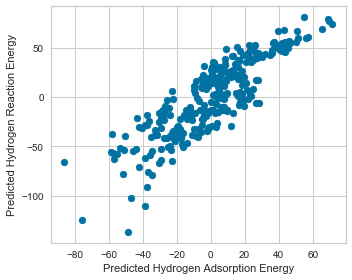

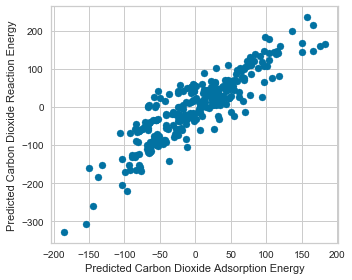

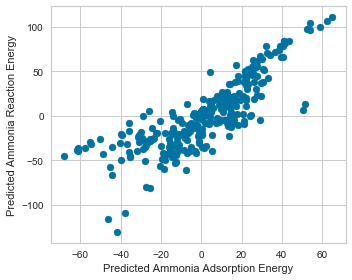

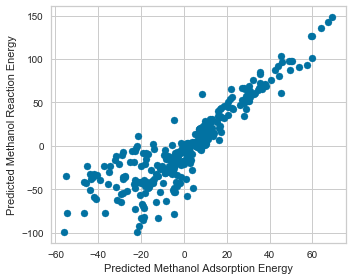

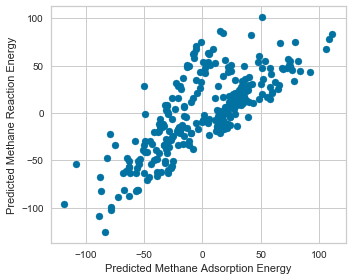

In [25]:


"""
for i,type in enumerate(New_names):
    xa = Comblib_transformed[i,0]
    ya = Comblib_transformed[i,1]
    plt.scatter(xa, ya)
    plt.text(xa+0.3, ya+0.3, type, fontsize=9)
    

"""
fig = plt.figure(figsize=(5, 4))
plt.scatter(preds_h2_a[0],preds_h2_r[0])
plt.xlabel('Predicted Hydrogen Adsorption Energy')
plt.ylabel('Predicted Hydrogen Reaction Energy')
#plt.xlim([-0.05,0.1])
#plt.ylim([-0.1,0.1])
plt.tight_layout()
#plt.savefig('H2_scatter.png',dpi=600)
plt.show()

fig = plt.figure(figsize=(5, 4))
plt.scatter(preds_co2_a[0],preds_co2_r[0])
plt.xlabel('Predicted Carbon Dioxide Adsorption Energy')
plt.ylabel('Predicted Carbon Dioxide Reaction Energy')
#plt.xlim([-0.05,0.1])
#plt.ylim([-0.1,0.1])
plt.tight_layout()
#plt.savefig('CO2_scatter.png',dpi=600)
plt.show()

fig = plt.figure(figsize=(5, 4))
plt.scatter(preds_nh3_a[0],preds_nh3_r[0])
plt.xlabel('Predicted Ammonia Adsorption Energy')
plt.ylabel('Predicted Ammonia Reaction Energy')
#plt.xlim([-0.05,0.1])
#plt.ylim([-0.1,0.1])
plt.tight_layout()
#plt.savefig('NH3_scatter.png',dpi=600)
plt.show()

fig = plt.figure(figsize=(5, 4))
plt.scatter(preds_ch3oh_a[0],preds_ch3oh_r[0])
plt.xlabel('Predicted Methanol Adsorption Energy')
plt.ylabel('Predicted Methanol Reaction Energy')
#plt.xlim([-0.05,0.1])
#plt.ylim([-0.1,0.1])
plt.tight_layout()
#plt.savefig('CH3OH_scatter.png',dpi=600)
plt.show()

fig = plt.figure(figsize=(5, 4))
plt.scatter(preds_ch4_a[0],preds_ch4_r[0])
plt.xlabel('Predicted Methane Adsorption Energy')
plt.ylabel('Predicted Methane Reaction Energy')
#plt.xlim([-0.05,0.1])
#plt.ylim([-0.1,0.1])
plt.tight_layout()
#plt.savefig('CH4_scatter.png',dpi=600)
plt.show()

In [26]:
err1 = []
for u in range(2,15):
    ism = Isomap(n_neighbors=u,n_components=10,neighbors_algorithm='kd_tree')
    y1 = ism.fit_transform(Comb_df) 
    err1.append(ism.reconstruction_error())
    
print(err1)
    
#fig = plt.figure()
#plt.plot(err)
#plt.show()
    #fig = plt.figure(figsize=(5, 4))
    #ax = fig.add_axes([0,0, .8, 1])
    #ax.scatter(y[:, 0], -y[:, 1])
    #plt.show()

err_diff1 = []
for m in range(1,len(err1)):
    err_diff1 = err1[m-1] - err1[m]
    if(err_diff1<0):
        print("Optimal number of nearest neighbours is %d" % (m+1))
        print("Reconstruction error is %d" % (err1[m-1]))
        break
        
ism2 = Isomap(n_neighbors=7,n_components=10,neighbors_algorithm='kd_tree')
y2 = ism2.fit_transform(Comb_df)
print(ism2.reconstruction_error())

[1030430.1083188639, 68706.11248040422, 34739.39755737345, 33027.71330303891, 27253.783411749966, 23388.362987312965, 23404.94348437621, 25892.684590225268, 22144.325041906333, 23244.673841790078, 21512.068323704567, 21800.610491985975, 20637.01146616384]
Optimal number of nearest neighbours is 7
Reconstruction error is 23388
23388.362987312965


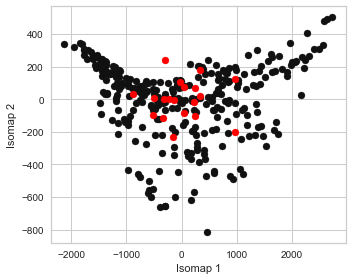

In [27]:
fig = plt.figure(figsize=(5, 4))
plt.scatter(Comblib_transformed[:,0],Comblib_transformed[:,1], c='k')
plt.scatter(y[:,0],y[:,1],c='red')
#plt.xlim([600,1500])
plt.xlabel('Isomap 1')
plt.ylabel('Isomap 2')
plt.tight_layout()
#plt.savefig('Isomap',dpi=600)
plt.show()

In [28]:
df_h2 = pd.DataFrame()
df_h2['Adsorption_Energy'] = preds_h2_a[0]
df_h2['Reaction_Energy'] = preds_h2_r[0]
#df_h2 = df_h2.set_index([0])
#df_h2.to_excel('Dummy_preds.xlsx')

In [ ]:
len(Comblib_transformed)

Novelty Detection in Predicted SAAs. 

We now use our predicted SAA energies to identify which combination of transition metals is the most suitable candidate for a given adsorbate. The analysis is divided into two key parts:

1. Detecting the skewness and kurtosis of the single atom alloy predictions for each adsorbate.
2. Understanding if the distribution is normal, heavy-tailed or light-tailed
3. Novelty detection using one class SVM

In [ ]:
#Calculate residuals from OLS Regression

#lm_h2 = LinearRegression().fit(h2_preds_a,h2_preds_r)

#print(lm_h2.score(h2_preds_a,h2_preds_r))

#print("Residual sum of squares: %.2f" % ((lm_h2.predict(h2_preds_a) - h2_preds_r) ** 2).sum())

In [ ]:
len(preds_h2_a[0])

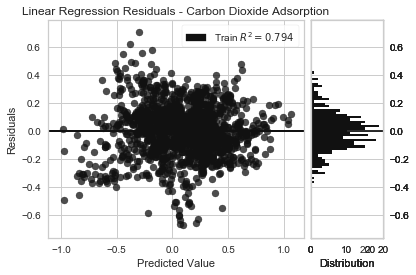

In [47]:
#h2_preds_a = np.reshape(preds_h2_a[0],(-1,1))
#h2_preds_r = np.reshape(preds_h2_r[0],(-1,1))

visualizer1 = ResidualsPlot(LinearRegression(),title="Linear Regression Residuals - Hydrogen Adsorption", train_color='k', test_color='k')
visualizer1.fit(h2_a_prediction, h2_r_prediction)
#visualizer1.score(h2_a_prediction, h2_r_prediction)
visualizer1.poof(outpath='Manuscript_for_submission_SAA/H2_residuals_v2.png', dpi=600)

#ch4_preds_a = np.reshape(preds_ch4_a[0],(-1,1))
#ch4_preds_r = np.reshape(preds_ch4_r[0],(-1,1))

visualizer2 = ResidualsPlot(LinearRegression(),title="Linear Regression Residuals - Methane Adsorption", train_color='k', test_color='k')
visualizer2.fit(ch4_a_prediction, ch4_r_prediction)
#visualizer2.score(ch4_a_prediction, ch4_r_prediction)
visualizer2.poof(outpath='Manuscript_for_submission_SAA/CH4_residuals_v2.png', dpi=600)

#nh3_preds_a = np.reshape(preds_nh3_a[0],(-1,1))
#nh3_preds_r = np.reshape(preds_nh3_r[0],(-1,1))

visualizer3 = ResidualsPlot(LinearRegression(),title="Linear Regression Residuals - Ammonia Adsorption", train_color='k', test_color='k')
visualizer3.fit(nh3_a_prediction, nh3_r_prediction)
#visualizer3.score(nh3_a_prediction, nh3_r_prediction)
visualizer3.poof(outpath='Manuscript_for_submission_SAA/NH3_residuals_v2.png', dpi=600)

#ch3oh_preds_a = np.reshape(preds_ch3oh_a[0],(-1,1))
#ch3oh_preds_r = np.reshape(preds_ch3oh_r[0],(-1,1))

visualizer4 = ResidualsPlot(LinearRegression(),title="Linear Regression Residuals - Methanol Adsorption", train_color='k', test_color='k')
visualizer4.fit(ch3oh_a_prediction, ch3oh_r_prediction)
#visualizer4.score(ch3oh_a_prediction, ch3oh_r_prediction)
visualizer4.poof(outpath='Manuscript_for_submission_SAA/CH3OH_residuals_v2.png', dpi=600)

#co2_preds_a = np.reshape(preds_co2_a[0],(-1,1))
#co2_preds_r = np.reshape(preds_co2_r[0],(-1,1))

visualizer5 = ResidualsPlot(LinearRegression(),title="Linear Regression Residuals - Carbon Dioxide Adsorption", train_color='k', test_color='k')
visualizer5.fit(co2_a_prediction, co2_r_prediction)
#visualizer5.score(co2_a_prediction, co2_r_prediction)
visualizer5.poof(outpath='Manuscript_for_submission_SAA/CO2_residuals_v2.png', dpi=600)

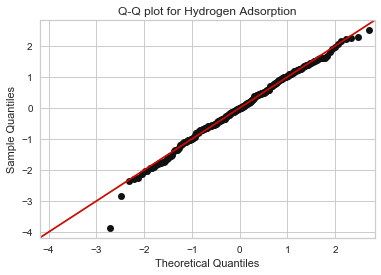

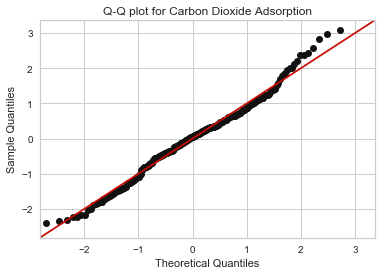

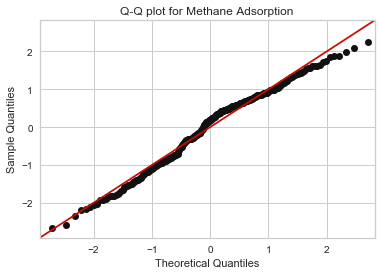

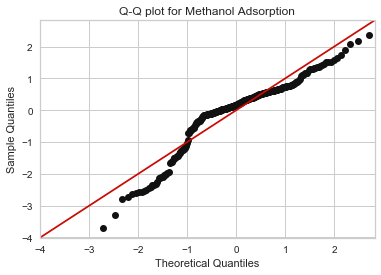

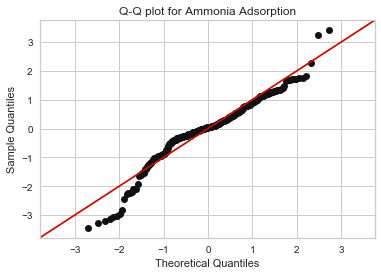

In [49]:
mod_fit1 = sm.OLS(h2_a_prediction, h2_r_prediction).fit()
res1 = mod_fit1.resid 
fig1 = sm.qqplot(res1,stats.norm,fit='True',line='45', markerfacecolor='k', markeredgecolor='k')
plt.title('Q-Q plot for Hydrogen Adsorption')
plt.savefig('Manuscript_for_submission_SAA/H2_qq_v2.png',dpi=600)
plt.show()

mod_fit2 = sm.OLS(co2_a_prediction, co2_r_prediction).fit()
res2 = mod_fit2.resid 
fig2 = sm.qqplot(res2,stats.norm,fit='True',line='45', markerfacecolor='k', markeredgecolor='k')
plt.title('Q-Q plot for Carbon Dioxide Adsorption')
plt.savefig('Manuscript_for_submission_SAA/CO2_qq_v2.png',dpi=600)
plt.show()

mod_fit3 = sm.OLS(ch4_a_prediction, ch4_r_prediction).fit()
res3 = mod_fit3.resid 
fig3 = sm.qqplot(res3,stats.norm,fit='True',line='45', markerfacecolor='k', markeredgecolor='k')
plt.title('Q-Q plot for Methane Adsorption')
plt.savefig('Manuscript_for_submission_SAA/CH4_qq_v2.png',dpi=600)
plt.show()

mod_fit4 = sm.OLS(ch3oh_a_prediction, ch3oh_r_prediction).fit()
res4 = mod_fit4.resid 
fig4 = sm.qqplot(res4,stats.norm,fit='True',line='45', markerfacecolor='k', markeredgecolor='k')
plt.title('Q-Q plot for Methanol Adsorption')
plt.savefig('Manuscript_for_submission_SAA/CH3OH_qq_v2.png',dpi=600)
plt.show()

mod_fit5 = sm.OLS(nh3_a_prediction, nh3_r_prediction).fit()
res5 = mod_fit5.resid 
fig5 = sm.qqplot(res5,stats.norm,fit='True',line='45', markerfacecolor='k', markeredgecolor='k')
plt.title('Q-Q plot for Ammonia Adsorption')
plt.savefig('Random3.png', dpi=600)
plt.savefig('Manuscript_for_submission_SAA/NH3_qq_v2.png',dpi=600)
plt.show()

In [50]:
res_h2 = np.reshape(res1,(-1,1))
outlier = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
y_out_h2 = outlier.fit_predict(res_h2)
out_scores_h2 = outlier.negative_outlier_factor_

res_co2 = np.reshape(res2,(-1,1))
y_out_co2 = outlier.fit_predict(res_co2)
out_scores_co2 = outlier.negative_outlier_factor_

res_ch4 = np.reshape(res3,(-1,1))
y_out_ch4 = outlier.fit_predict(res_ch4)
out_scores_ch4 = outlier.negative_outlier_factor_

res_ch3oh = np.reshape(res4,(-1,1))
y_out_ch3oh = outlier.fit_predict(res_ch3oh)
out_scores_ch3oh = outlier.negative_outlier_factor_

res_nh3 = np.reshape(res5,(-1,1))
y_out_nh3 = outlier.fit_predict(res_nh3)
out_scores_nh3 = outlier.negative_outlier_factor_

In [ ]:
np.sum(np.array(y_out_nh3) < 0, axis=0)

In [51]:
#Create pandas dataframe of adsorption energy, reaction energy, residual, 
#outlier prediction result and outlier prediction score

Final_alloy_names = Comb_df.index

#H2 dataframe
h2_pred_df = pd.DataFrame(Final_alloy_names)
h2_pred_df['Adsorption Energy'] = h2_a_prediction
h2_pred_df['Reaction Energy'] = h2_r_prediction
h2_pred_df['Residuals'] = res_h2
h2_pred_df['Outlier Y/N'] = y_out_h2
h2_pred_df['Outlier Score'] = out_scores_h2

#CO2 dataframe
co2_pred_df = pd.DataFrame(Final_alloy_names)
co2_pred_df['Adsorption Energy'] = co2_a_prediction
co2_pred_df['Reaction Energy'] = co2_r_prediction
co2_pred_df['Residuals'] = res_co2
co2_pred_df['Outlier Y/N'] = y_out_co2
co2_pred_df['Outlier Score'] = out_scores_co2

#CH3OH dataframe
ch3oh_pred_df = pd.DataFrame(Final_alloy_names)
ch3oh_pred_df['Adsorption Energy'] = ch3oh_a_prediction
ch3oh_pred_df['Reaction Energy'] = ch3oh_r_prediction
ch3oh_pred_df['Residuals'] = res_ch3oh
ch3oh_pred_df['Outlier Y/N'] = y_out_ch3oh
ch3oh_pred_df['Outlier Score'] = out_scores_ch3oh

#NH3 dataframe
nh3_pred_df = pd.DataFrame(Final_alloy_names)
nh3_pred_df['Adsorption Energy'] = nh3_a_prediction
nh3_pred_df['Reaction Energy'] = nh3_r_prediction
nh3_pred_df['Residuals'] = res_nh3
nh3_pred_df['Outlier Y/N'] = y_out_nh3
nh3_pred_df['Outlier Score'] = out_scores_nh3

#CH4 dataframe
ch4_pred_df = pd.DataFrame(Final_alloy_names)
ch4_pred_df['Adsorption Energy'] = ch4_a_prediction
ch4_pred_df['Reaction Energy'] = ch4_r_prediction
ch4_pred_df['Residuals'] = res_ch4
ch4_pred_df['Outlier Y/N'] = y_out_ch4
ch4_pred_df['Outlier Score'] = out_scores_ch4

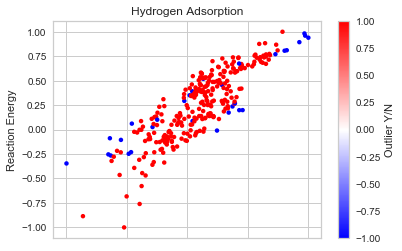

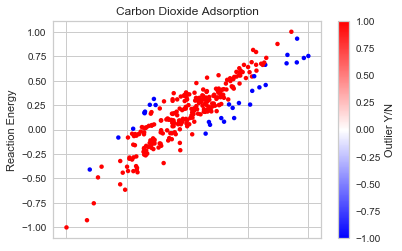

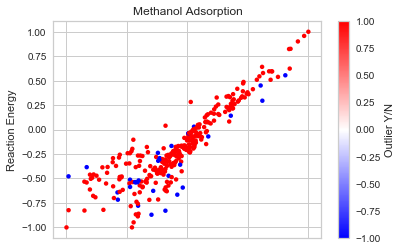

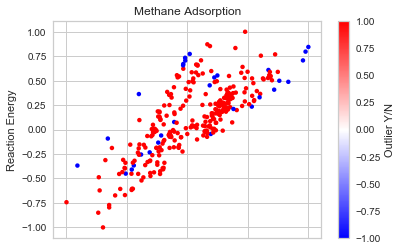

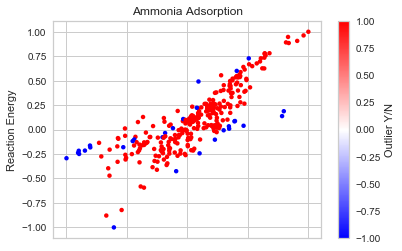

In [53]:
#Final Plot of Outlier in Regression Plot
axh2 = h2_pred_df.plot.scatter(x='Adsorption Energy',y='Reaction Energy',title='Hydrogen Adsorption',
                               c='Outlier Y/N',colormap='bwr', edgecolor='None')
figh2 = axh2.get_figure()
#figh2.savefig('Manuscript_for_submission_SAA/H2_outliers.png',dpi=600)

axco2 = co2_pred_df.plot.scatter(x='Adsorption Energy',y='Reaction Energy',title='Carbon Dioxide Adsorption',
                                 c='Outlier Y/N',colormap='bwr', edgecolor = 'None')
figco2 = axco2.get_figure()
#figco2.savefig('Manuscript_for_submission_SAA/CO2_outliers.png',dpi=600)

axch3oh = ch3oh_pred_df.plot.scatter(x='Adsorption Energy',y='Reaction Energy',title='Methanol Adsorption',
                                     c='Outlier Y/N',colormap='bwr', edgecolor='None')
figch3oh = axch3oh.get_figure()
#figch3oh.savefig('Manuscript_for_submission_SAA/CH3OH_outliers.png',dpi=600)

axch4 = ch4_pred_df.plot.scatter(x='Adsorption Energy',y='Reaction Energy',title='Methane Adsorption',
                                 c='Outlier Y/N',colormap='bwr', edgecolor='None')
figch4 = axch4.get_figure()
#figch4.savefig('Manuscript_for_submission_SAA/CH4_outliers.png',dpi=600)

axnh3 = nh3_pred_df.plot.scatter(x='Adsorption Energy',y='Reaction Energy',title='Ammonia Adsorption',
                                 c='Outlier Y/N',colormap='bwr', edgecolor='None')
fignh3 = axnh3.get_figure()
#fignh3.savefig('Manuscript_for_submission_SAA/NH3_outliers.png',dpi=600)

In [ ]:
query = -1

nh3_pred_df[nh3_pred_df['Outlier Y/N'] == query]

In [52]:
nh3_pred_df.to_excel('Manuscript_for_submission_SAA/NH3_outliers_v2.xlsx')

h2_pred_df.to_excel('Manuscript_for_submission_SAA/H2_outliers_v2.xlsx')

co2_pred_df.to_excel('Manuscript_for_submission_SAA/CO2_outliers_v2.xlsx')

ch3oh_pred_df.to_excel('Manuscript_for_submission_SAA/CH3OH_outliersv2.xlsx')

ch4_pred_df.to_excel('Manuscript_for_submission_SAA/CH4_outliers_v2.xlsx')

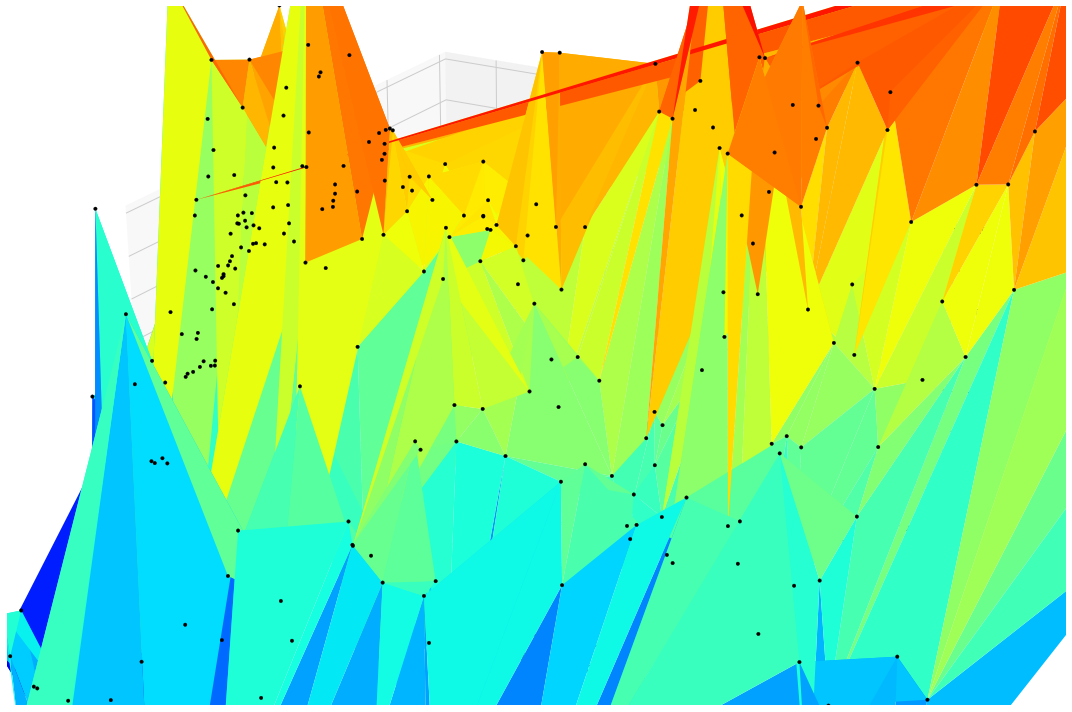

In [85]:
"""

## Figure for paper
fig_nh3_paper= plt.figure(figsize=[15,10])
ax_nh3_paper = plt.axes(projection='3d')
ax_nh3_paper.plot_trisurf(Comblib_transformed[:,0], Comblib_transformed[:,1], preds_nh3_a[0],
                cmap='jet', edgecolor='none')
ax_nh3_paper.scatter(Comblib_transformed[:,0], Comblib_transformed[:,1], preds_nh3_a[0],marker='.', s=50, c="black", alpha=1)
#ax3.view_init(elev=60, azim=-45)

#ax4.set_xlabel('Isomap 1')
#ax4.set_ylabel('Isomap 2')
#ax4.set_zlabel('Predicted Ammonia Adsorption Energy (eV)')
ax_nh3_paper.set_xlim([-750,1000])
ax_nh3_paper.set_ylim([-250,300])
ax_nh3_paper.set_zlim([-20,20])
plt.tight_layout()
fig_nh3_paper.savefig('Demo2.png',dpi=600)
plt.show()

""" 

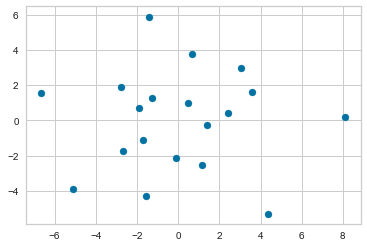

In [78]:
#plt.scatter(X_transformed[:,0], X_transformed[:,1])

In [128]:
#Suppl_df = pd.DataFrame(Comblib_transformed)
#Suppl_df = Suppl_df.set_index(Comb_df.index)

#h2_pred_df = h2_pred_df.set_index(h2_pred_df[0])
#Suppl_df[' Predicted Hydrogen Adsorption Energy (eV)'] = Suppl_df.index.map(h2_pred_df['Adsorption Energy'])
#Suppl_df[' Predicted Hydrogen Reaction Energy (eV)'] = Suppl_df.index.map(h2_pred_df['Reaction Energy'])

#ch4_pred_df = ch4_pred_df.set_index(ch4_pred_df[0])
#Suppl_df[' Predicted Methane Adsorption Energy (eV)'] = Suppl_df.index.map(ch4_pred_df['Adsorption Energy'])
#Suppl_df[' Predicted Methane Reaction Energy (eV)'] = Suppl_df.index.map(ch4_pred_df['Reaction Energy'])

#co2_pred_df = co2_pred_df.set_index(co2_pred_df[0])
#Suppl_df[' Predicted Carbon Dioxide Adsorption Energy (eV)'] = Suppl_df.index.map(co2_pred_df['Adsorption Energy'])
#Suppl_df[' Predicted Carbon Dioxide Reaction Energy (eV)'] = Suppl_df.index.map(co2_pred_df['Reaction Energy'])

#nh3_pred_df = nh3_pred_df.set_index(nh3_pred_df[0])
#Suppl_df[' Predicted Ammonia Adsorption Energy (eV)'] = Suppl_df.index.map(nh3_pred_df['Adsorption Energy'])
#Suppl_df[' Predicted Ammonia Reaction Energy (eV)'] = Suppl_df.index.map(nh3_pred_df['Reaction Energy'])

ch3oh_pred_df = ch3oh_pred_df.set_index(ch3oh_pred_df[0])
Suppl_df[' Predicted Methanol Adsorption Energy (eV)'] = Suppl_df.index.map(ch3oh_pred_df['Adsorption Energy'])
Suppl_df[' Predicted Methanol Reaction Energy (eV)'] = Suppl_df.index.map(ch3oh_pred_df['Reaction Energy'])

In [130]:
Suppl_df.to_excel('Manuscript_for_submission_SAA/Supplementary_Isomap_Preds.xlsx')